In [2]:
import numpy as np
import pandas as pd
# from shapely.geometry import Point, shape, LineString, mapping, MultiPoint
import seaborn
import geopandas as gpd
import pysal
import mapclassify
import matplotlib.pyplot as plt
from pysal.explore import esda
from pysal.lib import weights
import time
import random
import matplotlib.pyplot as plt
from shapely import wkt
from esda.moran import Moran
from libpysal.weights import Queen, KNN
import seaborn
import pandas
import geopandas
import numpy
import matplotlib.pyplot as plt


/Users/yuhan/opt/anaconda3/envs/hazard_env/lib/python3.11/site-packages/libpysal/cg/alpha_shapes.py:38: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit
/Users/yuhan/opt/anaconda3/envs/hazard_env/lib/python3.11/site-packages/libpysal/cg/alpha_shapes.py:164: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit
/Users/yuhan/opt/anaconda3/envs/hazard_env/lib/python

In [3]:
#df_final = pd.read_csv(r"/Users/yuhan/Desktop/paper——revision/data_county_hazard_year.csv")
df_final = pd.read_csv(r"/Users/yuhan/Desktop/paper——revision/df_final.csv")
HMA_PMD_pth = r"/Users/yuhan/Desktop/paper——revision/HMA_PMD.csv"
PDMData = pd.read_csv( HMA_PMD_pth )

print( df_final.columns)
print( "programFy unique ", PDMData.programFy.unique() )


Index(['fips', 'State Name', 'County Name', 'Year', 'Month',
       'sheldusdateplace', 'HMAprojAmot', 'HMAfedShaOb', 'subreciptAdm',
       'srmcOblgdAmt', 'AdminCostAmt', 'NumfinalProp', 'NumProperty',
       'duration_years', 'duration', 'Hazard', 'CropDmg', 'CropDmg(ADJ 2021)',
       'CropDmgPerCapita(ADJ 2021)', 'PropertyDmg', 'PropertyDmg(ADJ 2021)',
       'PropertyDmgPerCapita(ADJ 2021)', 'Injuries', 'InjuriesPerCapita',
       'Fatalities', 'FatalitiesPerCapita', 'Duration_Days',
       'disasterNumber_x', 'incidentdate_x', 'Count_h', 'ApprovLoan_h',
       'disasterNumber_y', 'incidentdate_y', 'Count_b', 'ApprovLoan_b',
       'disasterNumber', 'incidentdate', 'HAODamage', 'HAOCount', 'HAOAproved',
       'HAORepaRepl', 'HAORental', 'HAOOther', 'HARCount', 'HARAproved',
       'HARRepaRepl', 'HARRental', 'HAROther', 'PAprojectAmt', 'PAfedshare',
       'PAtotobl', 'NRI_ID', 'STATE', 'STATEABBRV', 'COUNTY', 'COUNTYTYPE',
       'STCOFIPS', 'POPULATION', 'BUILDVALUE', 'AGRIVAL

In [4]:
print( "old ", df_final.shape )
df_final = df_final[~df_final["State Name"].isin(['HAWAII','ALASKA', 'AMERICAN SAMOA', 'GUAM', 'PUERTO RICO', 'VIRGIN ISLANDS',
                                       'COMMONWEALTH OF THE NORTHERN MARIANA ISLANDS'])]
print( "new ", df_final.shape )

old  (162475, 83)
new  (159213, 83)


In [5]:
df_final["State Name"].unique()

array(['DELAWARE', 'ALABAMA', 'DISTRICT OF COLUMBIA', 'FLORIDA',
       'GEORGIA', 'IDAHO', 'ILLINOIS', 'INDIANA', 'IOWA', 'KANSAS',
       'KENTUCKY', 'LOUISIANA', 'MAINE', 'MARYLAND', 'MASSACHUSETTS',
       'MICHIGAN', 'MINNESOTA', 'MISSISSIPPI', 'MISSOURI', 'MONTANA',
       'NEBRASKA', 'NEVADA', 'NEW HAMPSHIRE', 'NEW JERSEY', 'NEW MEXICO',
       'NEW YORK', 'NORTH CAROLINA', 'NORTH DAKOTA', 'OHIO', 'OKLAHOMA',
       'ARIZONA', 'OREGON', 'PENNSYLVANIA', 'RHODE ISLAND',
       'SOUTH CAROLINA', 'SOUTH DAKOTA', 'TENNESSEE', 'TEXAS', 'UTAH',
       'VERMONT', 'ARKANSAS', 'VIRGINIA', 'WASHINGTON', 'WEST VIRGINIA',
       'WISCONSIN', 'WYOMING', 'CALIFORNIA', 'COLORADO', 'CONNECTICUT',
       nan], dtype=object)

In [6]:
#print( HMAData["County FIPS"] )
PDMData['FIPS'] = PDMData['FIPS'].apply(str)

print("before ", PDMData.shape)
PDMData         = PDMData.loc[ PDMData['programFy'] > 2000 ]
print("after", PDMData.shape)

PDMData['PDMcount'] = np.where( PDMData['projectAmount'] > 0, 1, 0)

PDMData_multiple    = PDMData.groupby(['FIPS', 'state', 'county', 'programFy']).agg({
                    'projectAmount'                 :  ['sum'], 
                    'PDMcount'                      :  ['sum'], 
                    'numberOfFinalProperties'       :  ['sum']   }).reset_index()

PDMData_multiple.columns = PDMData_multiple.columns.droplevel(1)
PDMData_multiple.columns = ['fips', 'state', 'county', 'Year', 'PDMprojAmot', 'PDMcount', 'PDMNumfinalProp']

print(PDMData_multiple.head())

before  (2828, 42)
after (2786, 42)
    fips     state      county    Year  PDMprojAmot  PDMcount  PDMNumfinalProp
0  10001  Delaware        Kent  2018.0     50000.00         1              0.0
1  10003  Delaware  New Castle  2007.0   1841825.00         1              2.0
2  10003  Delaware  New Castle  2009.0    858549.14         1              0.0
3  10003  Delaware  New Castle  2010.0    347639.97         1              2.0
4  10003  Delaware  New Castle  2011.0    100000.00         1              0.0


In [7]:
df_final['fips'].replace('', np.nan, inplace=True)
df_final.dropna(subset=['fips'], inplace=True)
df_final['fips']            = df_final['fips'].astype(int)
PDMData_multiple['fips']    = PDMData_multiple['fips'].apply(str).astype(int)
print( df_final.STCOFIPS.nunique() )

data_filterall_pdm          = pd.merge( df_final, PDMData_multiple, 
                              left_on=['fips', 'Year'], right_on=['fips', 'Year'], how='left')
print( "fips ", data_filterall_pdm.STCOFIPS.nunique() )

print( data_filterall_pdm.shape )


3105
fips  3105
(159208, 88)


In [10]:
print( data_filterall_pdm.head() )


    fips State Name County Name    Year  Month  sheldusdateplace  HMAprojAmot  \
0  10001   DELAWARE        Kent  2002.0    4.0      2.002041e+10          0.0   
1  10001   DELAWARE        Kent  2003.0    1.0      2.003011e+10          0.0   
2  10001   DELAWARE        Kent  2003.0    2.0      2.003021e+10          0.0   
3  10001   DELAWARE        Kent  2003.0    5.0      2.003051e+10          0.0   
4  10001   DELAWARE        Kent  2003.0    6.0      2.003061e+10          0.0   

   HMAfedShaOb  subreciptAdm  srmcOblgdAmt  ...       RESL_RATNG  RESL_SPCTL  \
0          0.0           0.0           0.0  ...  Relatively High    0.666667   
1          0.0           0.0           0.0  ...  Relatively High    0.666667   
2          0.0           0.0           0.0  ...  Relatively High    0.666667   
3          0.0           0.0           0.0  ...  Relatively High    0.666667   
4          0.0           0.0           0.0  ...  Relatively High    0.666667   

   RESL_VALUE          x        

In [15]:

print( data_filterall_pdm.columns )
data_filterall_pdm["YearMonth"] = data_filterall_pdm.Year * 100 + data_filterall_pdm.Month


Index(['fips', 'State Name', 'County Name', 'Year', 'Month',
       'sheldusdateplace', 'HMAprojAmot', 'HMAfedShaOb', 'subreciptAdm',
       'srmcOblgdAmt', 'AdminCostAmt', 'NumfinalProp', 'NumProperty',
       'duration_years', 'duration', 'Hazard', 'CropDmg', 'CropDmg(ADJ 2021)',
       'CropDmgPerCapita(ADJ 2021)', 'PropertyDmg', 'PropertyDmg(ADJ 2021)',
       'PropertyDmgPerCapita(ADJ 2021)', 'Injuries', 'InjuriesPerCapita',
       'Fatalities', 'FatalitiesPerCapita', 'Duration_Days',
       'disasterNumber_x', 'incidentdate_x', 'Count_h', 'ApprovLoan_h',
       'disasterNumber_y', 'incidentdate_y', 'Count_b', 'ApprovLoan_b',
       'disasterNumber', 'incidentdate', 'HAODamage', 'HAOCount', 'HAOAproved',
       'HAORepaRepl', 'HAORental', 'HAOOther', 'HARCount', 'HARAproved',
       'HARRepaRepl', 'HARRental', 'HAROther', 'PAprojectAmt', 'PAfedshare',
       'PAtotobl', 'NRI_ID', 'STATE', 'STATEABBRV', 'COUNTY', 'COUNTYTYPE',
       'STCOFIPS', 'POPULATION', 'BUILDVALUE', 'AGRIVAL

In [16]:
data_filterall_pdm['declared'] = np.where( ( (data_filterall_pdm['disasterNumber_x'] > 0) |
                                             (data_filterall_pdm['disasterNumber'] > 0) |
                                              (data_filterall_pdm['disasterNumber_y'] > 0) ) , 1, 0)
data_filterall_pdm['declared'].unique()

array([0, 1])

In [17]:
data_filterall_pdm['HazardCount'] = 1

data_filterall_pdm['HMAcount'] = np.where( data_filterall_pdm['HMAprojAmot'] > 0, 1, 0)
data_filterall_pdm['HAtotal']  = data_filterall_pdm['HAOAproved'] + data_filterall_pdm['HARAproved']

data_filterall_pdm['HAcount']  = np.where( ( ( data_filterall_pdm['HAOCount'] > 0 ) | (data_filterall_pdm['HARCount'] > 0) ), 1, 0)
data_filterall_pdm['PAcount']  = np.where(  data_filterall_pdm['PAprojectAmt'] > 0, 1, 0)

data_filterall_pdm['SBAcount']      = data_filterall_pdm['Count_h'] + data_filterall_pdm['Count_b']
data_filterall_pdm['SBAapproved']   = data_filterall_pdm['ApprovLoan_h'] + data_filterall_pdm['ApprovLoan_b']

data_filterall_pdm['SBAProjcount']  = np.where( ( (data_filterall_pdm['Count_h'] > 0) | (data_filterall_pdm['Count_b'] > 0)), 1, 0)

In [18]:
data_filterall_pdm.Hazard.value_counts()
print("YearMonth min ", data_filterall_pdm.YearMonth.min() )
print("YearMonth max ", data_filterall_pdm.YearMonth.max() )


YearMonth min  200101.0
YearMonth max  202112.0


In [51]:
data_filterall_pdm["time_range"] = pd.cut( data_filterall_pdm["YearMonth"], np.arange(200101.0, 202112.0, 2))

#data_filterall_pdm["time_range"] = data_filterall_pdm["time_range"].str

In [56]:

data_filterall_pdm.tail()


,fips,State Name,County Name,Year,Month,sheldusdateplace,HMAprojAmot,HMAfedShaOb,subreciptAdm,srmcOblgdAmt,...,HazardCount,HMAcount,HAtotal,HAcount,PAcount,SBAcount,SBAapproved,SBAProjcount,YearMonth,time_range
159203,9015,CONNECTICUT,Windham,2021.0,5.0,2.021051e+10,0.0,0.0,0.0,0.0,...,1,0,NaN,0,0,NaN,NaN,0,202105.0,"(202103.0, 202105.0]"
159204,9015,CONNECTICUT,Windham,2021.0,6.0,2.021061e+10,0.0,0.0,0.0,0.0,...,1,0,NaN,0,0,NaN,NaN,0,202106.0,"(202105.0, 202107.0]"
159205,9015,CONNECTICUT,Windham,2021.0,7.0,2.021071e+10,0.0,0.0,0.0,0.0,...,1,0,NaN,0,0,NaN,NaN,0,202107.0,"(202105.0, 202107.0]"
159206,9015,CONNECTICUT,Windham,2021.0,8.0,2.021081e+10,0.0,0.0,0.0,0.0,...,1,0,NaN,0,0,NaN,NaN,0,202108.0,"(202107.0, 202109.0]"
159207,9015,CONNECTICUT,Windham,2021.0,11.0,2.021111e+10,0.0,0.0,0.0,0.0,...,1,0,NaN,0,0,NaN,NaN,0,202111.0,"(202109.0, 202111.0]"


In [61]:
startdate = [] 
endsdate   = []
for key, value in data_filterall_pdm.iterrows(): 
    #print( value["time_range"] )
    try:
        startdate.append( value["time_range"].left )
        endsdate.append( value["time_range"].right )
    except:
        #print( value["time_range"] )
        startdate.append( 0 )
        endsdate.append( 0 )

data_filterall_pdm["startdate"] = startdate
data_filterall_pdm["enddate"]   = endsdate



In [62]:
data_filterall_pdm

,fips,State Name,County Name,Year,Month,sheldusdateplace,HMAprojAmot,HMAfedShaOb,subreciptAdm,srmcOblgdAmt,...,HAtotal,HAcount,PAcount,SBAcount,SBAapproved,SBAProjcount,YearMonth,time_range,startdate,enddate
0,10001,DELAWARE,Kent,2002.0,4.0,2.002041e+10,0.0,0.0,0.0,0.0,...,NaN,0,0,NaN,NaN,0,200204.0,"(200203.0, 200205.0]",200203.0,200205.0
1,10001,DELAWARE,Kent,2003.0,1.0,2.003011e+10,0.0,0.0,0.0,0.0,...,NaN,0,0,NaN,NaN,0,200301.0,"(200299.0, 200301.0]",200299.0,200301.0
2,10001,DELAWARE,Kent,2003.0,2.0,2.003021e+10,0.0,0.0,0.0,0.0,...,NaN,0,0,NaN,NaN,0,200302.0,"(200301.0, 200303.0]",200301.0,200303.0
3,10001,DELAWARE,Kent,2003.0,5.0,2.003051e+10,0.0,0.0,0.0,0.0,...,NaN,0,0,NaN,NaN,0,200305.0,"(200303.0, 200305.0]",200303.0,200305.0
4,10001,DELAWARE,Kent,2003.0,6.0,2.003061e+10,0.0,0.0,0.0,0.0,...,NaN,0,0,NaN,NaN,0,200306.0,"(200305.0, 200307.0]",200305.0,200307.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
159203,9015,CONNECTICUT,Windham,2021.0,5.0,2.021051e+10,0.0,0.0,0.0,0.0,...,NaN,0,0,NaN,NaN,0,202105.0,"(202103.0, 202105.0]",202103.0,202105.0
159204,9015,CONNECTICUT,Windham,2021.0,6.0,2.021061e+10,0.0,0.0,0.0,0.0,...,NaN,0,0,NaN,NaN,0,202106.0,"(202105.0, 202107.0]",202105.0,202107.0
159205,9015,CONNECTICUT,Windham,2021.0,7.0,2.021071e+10,0.0,0.0,0.0,0.0,...,NaN,0,0,NaN,NaN,0,202107.0,"(202105.0, 202107.0]",202105.0,202107.0
159206,9015,CONNECTICUT,Windham,2021.0,8.0,2.021081e+10,0.0,0.0,0.0,0.0,...,NaN,0,0,NaN,NaN,0,202108.0,"(202107.0, 202109.0]",202107.0,202109.0


In [60]:
print(len( data_filterall_pdm.fips.unique() ) )
print(data_filterall_pdm.shape)


3108
(159208, 101)


In [238]:
print( data_filterall_pdm.declared.unique() )
data_declared_pdm = data_filterall_pdm.loc[ data_filterall_pdm["declared"] == 1 ]

[0 1]


In [239]:

data_county_hazard_year = data_declared_pdm.groupby([ 'fips' , 'startdate', 'enddate'], as_index=False).agg({  
                                    'Hazard'      :  ', '.join ,
                                    'HMAprojAmot' :  ['sum'],  'AdminCostAmt' :  ['sum'], 
                                    'NumfinalProp' :  ['sum'], 
                                    'CropDmg' :  ['sum'], 'CropDmg(ADJ 2021)' :  ['sum'], 
                                    'CropDmgPerCapita(ADJ 2021)' :  ['sum'],
                                    'PropertyDmg' :   ['sum' ],  
                                    'PropertyDmg(ADJ 2021)' :  ['sum'],
                                    'PropertyDmgPerCapita(ADJ 2021)' :  ['sum'],
                                    'Injuries' :  ['sum'], 'InjuriesPerCapita' :  ['sum'], 
                                    'Fatalities' :  ['sum'], 'FatalitiesPerCapita' :  ['sum'], 
                                    'Duration_Days' :  ['sum'],  'PAprojectAmt' :  ['sum'],                          
                                    'PDMprojAmot' :  ['sum'], 'PDMcount' :  ['sum'], 
                                    'PDMNumfinalProp' :  ['sum'], 'HMAcount' :  ['sum'], 'HAtotal' :  ['sum'],
                                    'HAcount' :  ['sum'], 'PAcount' :  ['sum'], 'SBAcount' :  ['sum'], 
                                    'SBAProjcount' :  ['sum'], 'SBAapproved' :  ['sum'],
                                    'HazardCount': ['sum'], 'x': ['mean'], 'y': ['mean']
                                      }).reset_index()

data_county_hazard_year.columns = data_county_hazard_year.columns.droplevel(1)
print( data_county_hazard_year.head() )

   index  fips  startdate   enddate                      Hazard  HMAprojAmot  \
0      0  1001   200109.0  200111.0                     Tornado          0.0   
1      1  1001   200407.0  200409.0                    Flooding     212414.0   
2      2  1001   200507.0  200509.0    Hurricane/Tropical Storm     215762.0   
3      3  1001   200903.0  200905.0  Severe Storm/Thunder Storm          0.0   
4      4  1001   201103.0  201105.0  Severe Storm/Thunder Storm     248655.0   

   AdminCostAmt  NumfinalProp   CropDmg  CropDmg(ADJ 2021)  ...  HMAcount  \
0           0.0           0.0       0.0               0.00  ...         0   
1         777.0          51.0  300000.0          418053.96  ...         1   
2         720.0          44.0       0.0               0.00  ...         1   
3           0.0           0.0       0.0               0.00  ...         0   
4           0.0          45.0       0.0               0.00  ...         1   

      HAtotal  HAcount  PAcount  SBAcount  SBAProjcount 

In [240]:
print( data_county_hazard_year.shape )
print( data_county_hazard_year.loc[ data_county_hazard_year['HazardCount'] > 1 ].shape )


(8645, 33)
(914, 33)


In [241]:
hazard_names            = ['Severe Storm/Thunder Storm', 'Wind', 'Flooding', 'Winter Weather', 'Hail', 
                            'Tornado', 'Lightning', 'Drought', 'Hurricane/Tropical Storm', 'Wildfire', 
                            'Heat', 'Coastal', 'Avalanche', 'Landslide', 'Fog', 'Tsunami/Seiche', 'Earthquake', 'Volcano']
hazard_values           = list( range( len(hazard_names) ) )


In [242]:
print( hazard_names )
print( values )

['Severe Storm/Thunder Storm', 'Wind', 'Flooding', 'Winter Weather', 'Hail', 'Tornado', 'Lightning', 'Drought', 'Hurricane/Tropical Storm', 'Wildfire', 'Heat', 'Coastal', 'Avalanche', 'Landslide', 'Fog', 'Tsunami/Seiche', 'Earthquake', 'Volcano']
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]


In [243]:
print( len(data_county_hazard_year.Hazard.unique() ) )
print( data_county_hazard_year.Hazard.unique() )


151
['Tornado' 'Flooding' 'Hurricane/Tropical Storm'
 'Severe Storm/Thunder Storm' 'Wind'
 'Tornado, Tornado, Tornado, Tornado, Tornado, Tornado, Tornado, Tornado'
 'Lightning, Lightning, Lightning, Lightning, Lightning, Lightning, Lightning, Lightning'
 'Tornado, Tornado'
 'Flooding, Flooding, Flooding, Flooding, Flooding, Flooding, Flooding, Flooding'
 'Hail' 'Flooding, Flooding'
 'Severe Storm/Thunder Storm, Severe Storm/Thunder Storm, Severe Storm/Thunder Storm, Severe Storm/Thunder Storm'
 'Severe Storm/Thunder Storm, Severe Storm/Thunder Storm, Severe Storm/Thunder Storm, Severe Storm/Thunder Storm, Severe Storm/Thunder Storm, Severe Storm/Thunder Storm, Severe Storm/Thunder Storm, Severe Storm/Thunder Storm'
 'Severe Storm/Thunder Storm, Severe Storm/Thunder Storm'
 'Hurricane/Tropical Storm, Hurricane/Tropical Storm, Hurricane/Tropical Storm, Hurricane/Tropical Storm'
 'Lightning' 'Hurricane/Tropical Storm, Hurricane/Tropical Storm'
 'Hurricane/Tropical Storm, Hurricane/Tropica

In [244]:
n_hazard = len(hazard_names)
Mat = np.zeros( (n_hazard, n_hazard) )
new_data = []

for idx, row in data_county_hazard_year.iterrows():
    hazardsi = row['Hazard'].split(', ')
    compund = 0
    #print(row['Hazard'])
    if type( hazardsi ) == list:
        if len( hazardsi ) > 1:
            res = [ (a, b) for idx, a in enumerate(hazardsi) for b in hazardsi[idx + 1:]]
            #print( res )
            for hazi in res:
                hazard1 = hazi[0]
                hazard2 = hazi[1]
                hazards1_id = hazard_values[ hazard_names.index( hazi[0] ) ]
                hazards2_id = hazard_values[ hazard_names.index( hazi[1] ) ]
                if hazards2_id == hazards1_id:
                    Mat[ hazards1_id, hazards2_id ] = Mat[ hazards1_id, hazards2_id ] + 0
                    Mat[ hazards2_id, hazards1_id ] = Mat[ hazards2_id, hazards1_id ] + 0
                    datai = {
                        'fips': row['fips'], 'startdate': row['startdate'], 'Hazard1': hazard1, 
                        'Hazard2': hazard2, 'HMAprojAmot': row['HMAprojAmot'], 'CropDmg': row['CropDmg'],
                        'PropertyDmg': row['PropertyDmg'], 'Injuries': row['Injuries'], 'Fatalities': row['Fatalities'],
                        'PAprojectAmt': row['PAprojectAmt'], 'PDMprojAmot': row['PDMprojAmot'], 'PDMcount': row['PDMcount'],
                        'HMAcount': row['HMAcount'], 'HAtotal': row['HAtotal'], 'HAcount': row['HAcount'],
                        'PAcount': row['PAcount'], 'SBAcount': row['SBAcount'], 'SBAProjcount': row['SBAProjcount'],
                        'SBAapproved': row['SBAapproved'], 'HazardCount': row['HazardCount'], 'CompundHazard': 0
                    }
                else:
                    Mat[ hazards1_id, hazards2_id ] = Mat[ hazards1_id, hazards2_id ] + 1
                    Mat[ hazards2_id, hazards1_id ] = Mat[ hazards2_id, hazards1_id ] + 1
                    datai = {
                        'fips': row['fips'], 'startdate': row['startdate'], 'Hazard1': hazard1, 
                        'Hazard2': hazard2, 'HMAprojAmot': row['HMAprojAmot'], 'CropDmg': row['CropDmg'],
                        'PropertyDmg': row['PropertyDmg'], 'Injuries': row['Injuries'], 'Fatalities': row['Fatalities'],
                        'PAprojectAmt': row['PAprojectAmt'], 'PDMprojAmot': row['PDMprojAmot'], 'PDMcount': row['PDMcount'],
                        'HMAcount': row['HMAcount'], 'HAtotal': row['HAtotal'], 'HAcount': row['HAcount'],
                        'PAcount': row['PAcount'], 'SBAcount': row['SBAcount'], 'SBAProjcount': row['SBAProjcount'],
                        'SBAapproved': row['SBAapproved'], 'HazardCount': row['HazardCount'], 'CompundHazard': 1
                    }
                new_data.append( datai )
        else:
            hazardsi_idx = hazard_values[ hazard_names.index( hazardsi[0] ) ]
            Mat[hazardsi_idx, hazardsi_idx] = Mat[hazardsi_idx, hazardsi_idx] + 0
            datai = {
                    'fips': row['fips'], 'startdate': row['startdate'], 'Hazard1': hazardsi[0], 
                    'Hazard2': hazardsi[0], 'HMAprojAmot': row['HMAprojAmot'], 'CropDmg': row['CropDmg'],
                    'PropertyDmg': row['PropertyDmg'], 'Injuries': row['Injuries'], 'Fatalities': row['Fatalities'],
                    'PAprojectAmt': row['PAprojectAmt'], 'PDMprojAmot': row['PDMprojAmot'], 'PDMcount': row['PDMcount'],
                    'HMAcount': row['HMAcount'], 'HAtotal': row['HAtotal'], 'HAcount': row['HAcount'],
                    'PAcount': row['PAcount'], 'SBAcount': row['SBAcount'], 'SBAProjcount': row['SBAProjcount'],
                    'SBAapproved': row['SBAapproved'], 'HazardCount': row['HazardCount'], 'CompundHazard': 0
                }
            new_data.append( datai )
    else:
        hazardsi_idx = hazard_values[ hazard_names.index( hazardsi ) ]
        Mat[hazardsi_idx, hazardsi_idx] = Mat[hazardsi_idx, hazardsi_idx] + 0
        datai = {
                    'fips': row['fips'], 'startdate': np.floor( row['startdate']/100 ), 'Hazard1': hazardsi, 
                    'Hazard2': hazardsi, 'HMAprojAmot': row['HMAprojAmot'], 'CropDmg': row['CropDmg'],
                    'PropertyDmg': row['PropertyDmg'], 'Injuries': row['Injuries'], 'Fatalities': row['Fatalities'],
                    'PAprojectAmt': row['PAprojectAmt'], 'PDMprojAmot': row['PDMprojAmot'], 'PDMcount': row['PDMcount'],
                    'HMAcount': row['HMAcount'], 'HAtotal': row['HAtotal'], 'HAcount': row['HAcount'],
                    'PAcount': row['PAcount'], 'SBAcount': row['SBAcount'], 'SBAProjcount': row['SBAProjcount'],
                    'SBAapproved': row['SBAapproved'], 'HazardCount': row['HazardCount'], 'CompundHazard': 0
                }
        new_data.append( datai )

new_county_hazard_year = pd.DataFrame(new_data)

In [246]:
Mat.max(), Mat.min()

(154.0, 0.0)

In [247]:
import pandas as pd
import numpy as np

hazard_names2 = ['Severe Storm', 'Wind', 'Flooding', 'Winter Weather', 'Hail', 
                'Tornado', 'Lightning', 'Drought', 'Hurricane', 'Wildfire', 
                'Heat', 'Coastal', 'Avalanche', 'Landslide', 'Fog', 'Tsunami', 'Earthquake', 'Volcano']

#rs = np.random.RandomState(0)
Mat2 = Mat[0:9, 0:9]
df = pd.DataFrame( Mat2 )
df.columns = hazard_names2[0:9]
df.index = hazard_names2[0:9]

print( df.columns )
df.style.background_gradient(cmap='coolwarm')

Index(['Severe Storm', 'Wind', 'Flooding', 'Winter Weather', 'Hail', 'Tornado',
       'Lightning', 'Drought', 'Hurricane'],
      dtype='object')


,Severe Storm,Wind,Flooding,Winter Weather,Hail,Tornado,Lightning,Drought,Hurricane
Severe Storm,0.000000,11.000000,75.000000,0.000000,4.000000,2.000000,0.000000,0.000000,68.000000
Wind,11.000000,0.000000,38.000000,0.000000,0.000000,0.000000,20.000000,0.000000,2.000000
Flooding,75.000000,38.000000,0.000000,2.000000,3.000000,25.000000,6.000000,0.000000,154.000000
Winter Weather,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Hail,4.000000,0.000000,3.000000,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000
Tornado,2.000000,0.000000,25.000000,0.000000,3.000000,0.000000,0.000000,0.000000,14.000000
Lightning,0.000000,20.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,71.000000
Drought,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Hurricane,68.000000,2.000000,154.000000,0.000000,0.000000,14.000000,71.000000,0.000000,0.000000


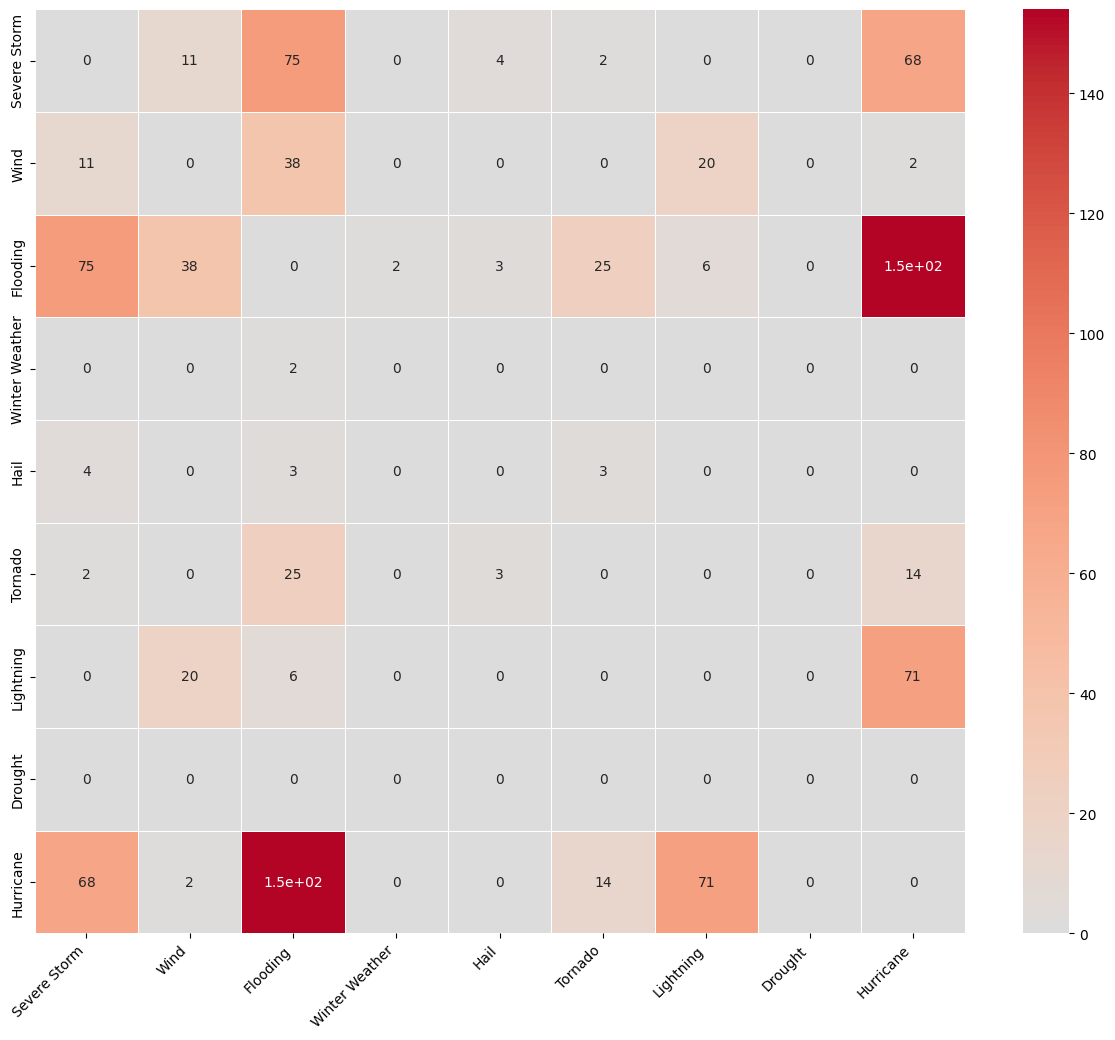

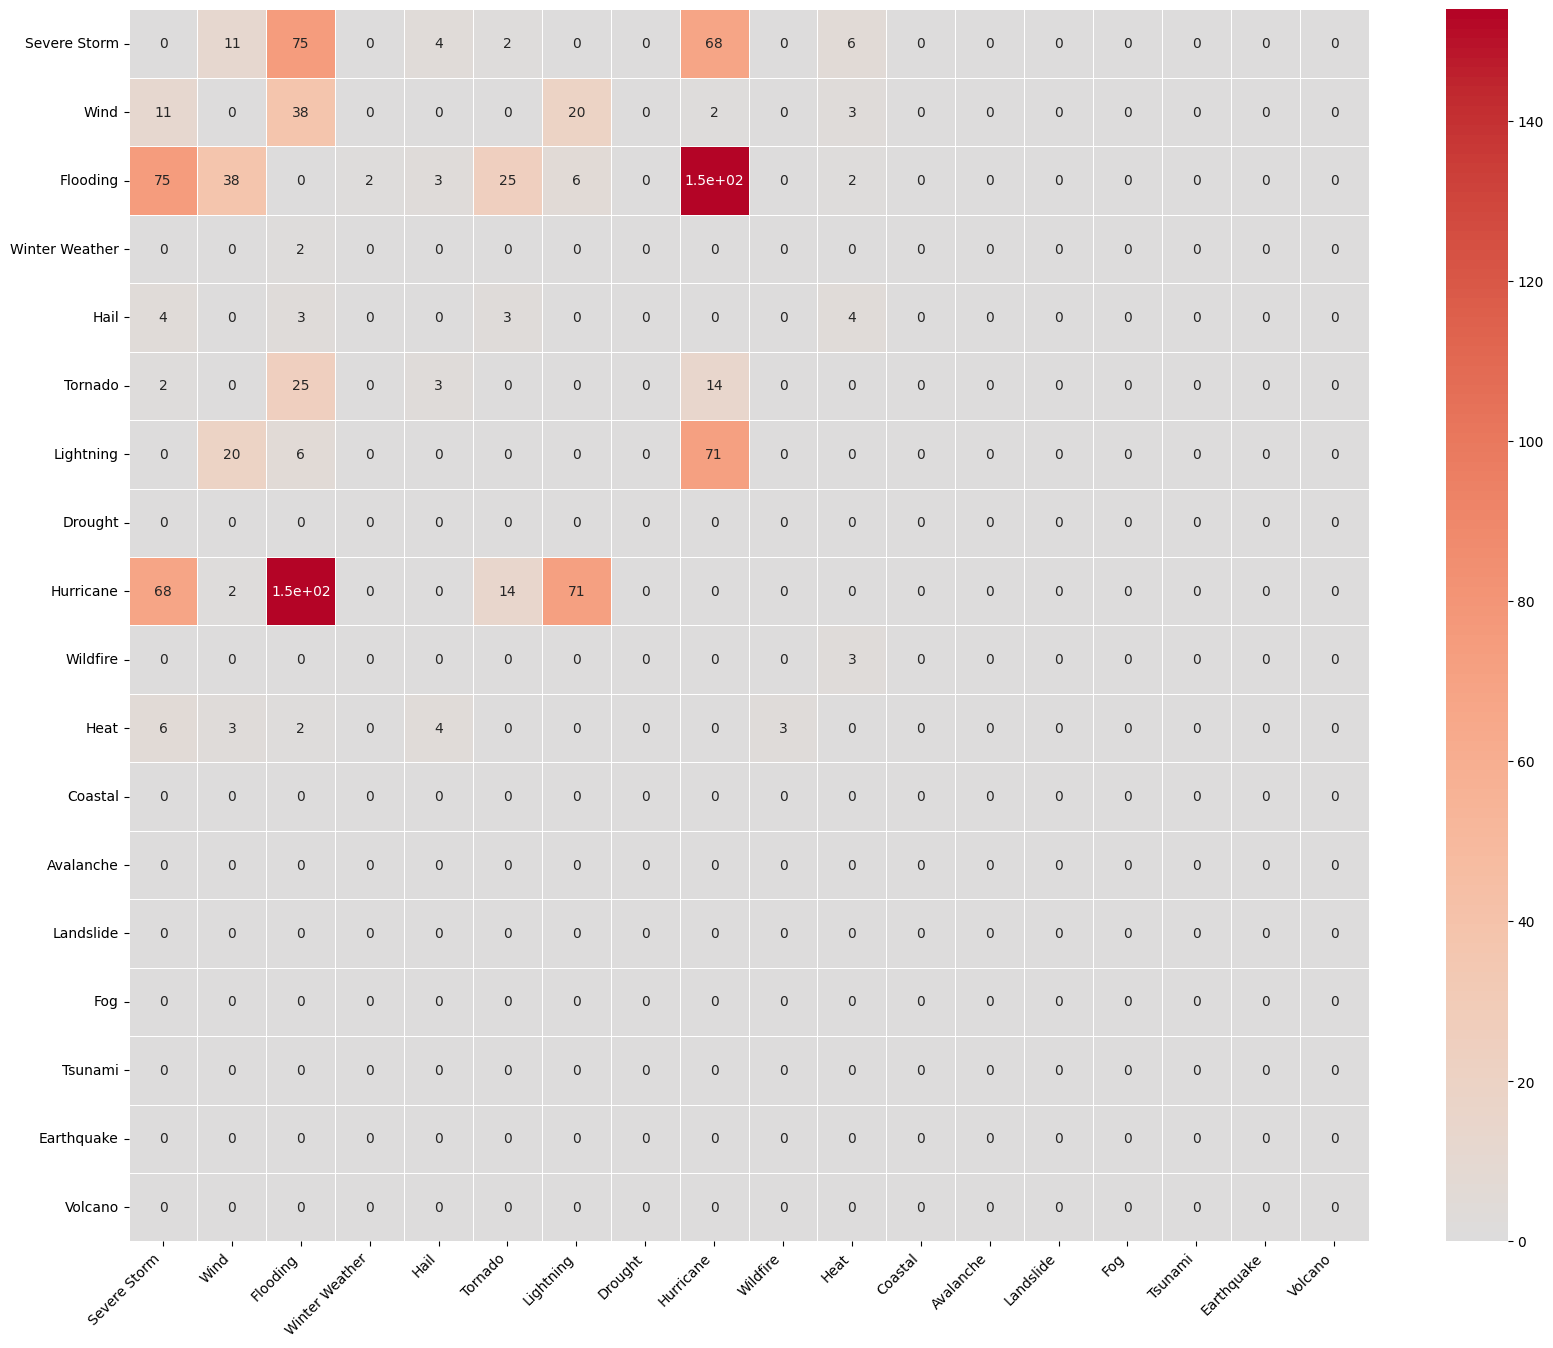

In [262]:
f, ax = plt.subplots(figsize=(15, 12))
ax = seaborn.heatmap( df, 
                     vmin= 0, vmax= 154.0, center = 0, 
                     square=False, cmap="coolwarm", annot=True, linewidth=.5
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation= 45,
    horizontalalignment='right'
);
#f.savefig('/Users/yuhan/Desktop/figcorr.png', dpi=1000)


df2 = pd.DataFrame( Mat )
df2.columns = hazard_names2
df2.index = hazard_names2

f, ax = plt.subplots(figsize=(20, 16))
ax = seaborn.heatmap( df2, 
                     vmin= 0, vmax= 154.0, center = 0, 
                     square=False, cmap="coolwarm", annot=True , linewidth=.5
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation= 45,
    horizontalalignment='right'
);
#f.savefig('/Users/yuhan/Desktop/figcorr_all.png', dpi=1000)


In [254]:
new_county_hazard_year["year"] = np.floor( new_county_hazard_year["startdate"] / 100 ) 
new_county_hazard_year.head()


,fips,startdate,Hazard1,Hazard2,HMAprojAmot,CropDmg,PropertyDmg,Injuries,Fatalities,PAprojectAmt,...,HMAcount,HAtotal,HAcount,PAcount,SBAcount,SBAProjcount,SBAapproved,HazardCount,CompundHazard,year
0,1001,200109.0,Tornado,Tornado,0.0,0.0,40000.0,0.0,0.0,0.0,...,0,0.00,0,0,0.0,1,0.0,1,0,2001.0
1,1001,200407.0,Flooding,Flooding,212414.0,300000.0,7824000.0,0.0,0.0,0.0,...,1,1871322.13,1,0,33.0,1,863400.0,1,0,2004.0
2,1001,200507.0,Hurricane/Tropical Storm,Hurricane/Tropical Storm,215762.0,0.0,160000.0,0.0,0.0,0.0,...,1,0.00,0,0,0.0,1,0.0,1,0,2005.0
3,1001,200903.0,Severe Storm/Thunder Storm,Severe Storm/Thunder Storm,0.0,0.0,545000.0,0.0,0.0,0.0,...,0,2019303.00,1,0,8.0,1,145900.0,1,0,2009.0
4,1001,201103.0,Severe Storm/Thunder Storm,Severe Storm/Thunder Storm,248655.0,0.0,7603800.0,12.0,9.0,0.0,...,1,3796918.53,1,0,3.0,1,151300.0,1,0,2011.0


In [258]:

compundhazard_year = new_county_hazard_year.groupby( [ 'year' ] ).agg({
    'CompundHazard'      :  ['sum']
})
compundhazard_year['year'] = compundhazard_year.index
compundhazard_year.columns = [ "CompundCount", "year" ]
compundhazard_year

,CompundCount,year
year,,
0.0,0,0.0
2001.0,0,2001.0
2002.0,1,2002.0
2003.0,0,2003.0
2004.0,205,2004.0
2005.0,159,2005.0
2006.0,1,2006.0
2007.0,0,2007.0
2008.0,38,2008.0


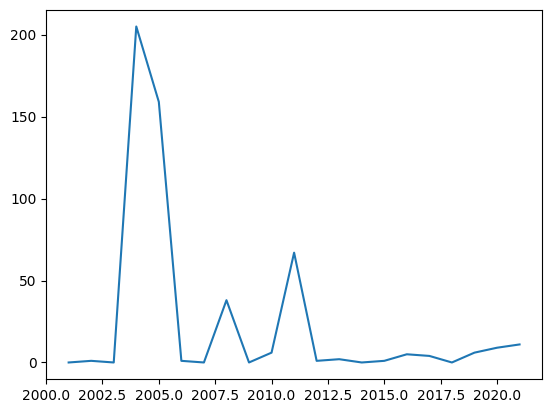

In [257]:
plt.plot( compundhazard_year['year'][1:], compundhazard_year['CompundCount'][1:] )